In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

usar_gpu = torch.cuda.is_available()
# usar_gpu = False
if usar_gpu:
    print("CUDA disponível. Processamento em GPU!")
else:
    print("CUDA NÃO disponível. Processamento em CPU!")


CUDA disponível. Processamento em GPU!


In [3]:
class NeuralNet(nn.Module):
    def __init__(self) -> None:
        super(NeuralNet, self).__init__()

        self.seq1 = nn.Sequential(nn.Linear(5, 10), nn.Sigmoid())
        self.seq2 = nn.Sequential(nn.Linear(10, 50), nn.ReLU(inplace=True))
        self.seq21 = nn.Sequential(nn.Linear(50, 50), nn.ReLU(inplace=True))
        self.seq3 = nn.Sequential(nn.Linear(50, 10), nn.ReLU(inplace=True))
        self.seq4 = nn.Sequential(nn.Linear(10, 2), nn.Sigmoid())

    def forward(self, x):
        o = self.seq1(x)
        o = self.seq2(o)
        o = self.seq21(o)
        o = self.seq3(o)
        o = self.seq4(o)

        return o


In [4]:
class MFPTDataset(Dataset):
    def __init__(self, xs, ys) -> None:
        super().__init__()
        self.features = xs
        self.labels = ys

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index) :
        return self.features[index], self.labels[index]

data = np.load("MFPT_Features.npz")

x, y = data["x_features"], data["y_labels"]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=4)

batch_size = 25
train_loader = DataLoader(MFPTDataset(xtrain, ytrain), batch_size, shuffle=True)
test_loader = DataLoader(MFPTDataset(xtest, ytest), batch_size, shuffle=True)

print("train shapes:", xtrain.shape, ytrain.shape)
print("test shapes: ", xtest.shape, ytest.shape)


train shapes: (1019, 5) (1019,)
test shapes:  (437, 5) (437,)


In [5]:
model = NeuralNet()
# print(model)

if usar_gpu:
    torch.cuda.init()
    model.cuda()
    cudnn.benchmark = True

In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoca 500/500 	 Loss de Treinamento: 0.013667087070643902


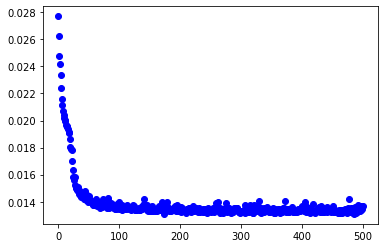

In [7]:
n_epochs = 500

loss_total = 0
for e in range(n_epochs):
    model.train()
    for batch_idx, (x, y) in enumerate(train_loader):
        if usar_gpu:
            x, y = x.float().cuda(), y.cuda()
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        loss_total += loss

    # model.eval()
    # score = 0
    # loss_test = 0
    # target_true = 0
    # pred_true = 0
    # correct_true = 0
    # for (x, y) in test_loader:
    #     if usar_gpu:
    #         x, y = x.float().cuda(), y.cuda()

    #     eout = model(x)
    #     loss = criterion(eout, y)
    #     loss_test += loss

    #     _, predicted = torch.max(eout.data, 1)

    #     for label, pred in zip(y, predicted):
    #         if label == pred:
    #             score += 1

        # fscore
    #     target_true += torch.sum(y == 1).float()
    #     pred_true += torch.sum(predicted == 1).float()
    #     correct_true += torch.sum((pred_true == y[:]) * (predicted == 1)).float()
    #     print(correct_true)
    # plt.scatter(e, loss_test.detach().cpu().numpy(), c='red')
    # recall = correct_true/target_true
    # precision = correct_true / pred_true
    # fscore = 2 * precision * recall / (precision + recall)
    # print(fscore)
        

    loss_total = loss_total / len(ytrain)
    plt.scatter(e, loss_total.detach().cpu().numpy(), c='blue')
print(f"Epoca {e+1}/{n_epochs} \t Loss de Treinamento: {loss_total}")
plt.show()


In [66]:
model.eval()

loss_test = 0

score = 0

ttp = 0
ttn = 0
tfn = 0
tfp = 0
correct_true = 0
total_elem = 0


def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    # true_positives = torch.sum(confusion_vector == 1).item()
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float("inf")).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives


ytrue = []
ypred = []
with torch.no_grad():
    for (x, y) in test_loader:
        if usar_gpu:
            x, y = x.float().cuda(), y.cuda()

        eout = model(x)
        loss = criterion(eout, y)
        loss_test += loss
        _, predicted = torch.max(eout.data, 1)

        tp, fp, tn, fn = confusion(predicted, y)
        total_elem += tp + fp + tn + fn
        ttp += tp
        ttn += tn
        tfp += fp
        tfn += fn
        # print(tp, fp, tn, fn)
        score += torch.sum(predicted == y).float()

        # conf matrix
        ytrue.append(y.detach().cpu().numpy().flatten())
        ypred.append(predicted.detach().cpu().numpy().flatten())


precision = ttp / (ttp + tfp)
recall = ttp / (ttp + tfn)
fscore = ttp / (ttp + (tfp + tfn) / 2)

print(f"precis: {precision}")
print(f"recall: {recall}")
print(f"fscore: {fscore}")
print(f"acc:    {score/len(ytest)}, score: {score}, len: {len(ytest)}")
print(f"acc:    {(ttp+ttn)/(total_elem)}, total_elem: {total_elem}")

print("matriz de confusão:")
cm = np.array([[ttp, tfn], [tfp, ttn]])
# cm = cm / cm.sum()
print(cm)

# TODO
# analisar o desbalanceamento dos dados
# ver isso na aula em que ele explica direitinho sobre o f-score/measure
# também plotar a matriz de confusão


precis: 0.9965870307167235
recall: 0.9864864864864865
fscore: 0.9915110356536503
acc:    0.988558292388916, score: 432.0, len: 437
acc:    0.988558352402746, total_elem: 437
matriz de confusão:
[[292   4]
 [  1 140]]


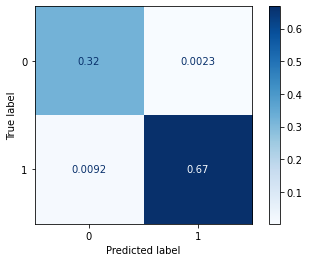

In [73]:
import sklearn.metrics as metrics

# metrics.confusion_matrix()
yt = np.array( ytrue[0])
for i in range(1,len(ytrue)):
    yt = np.concatenate((yt, ytrue[i]))

yp = np.array( ypred[0])
for i in range(1,len(ypred)):
    yp = np.concatenate((yp, ypred[i]))

metrics.confusion_matrix(yt, yp)
metrics.ConfusionMatrixDisplay.from_predictions(yt, yp, normalize='all', cmap='Blues')
plt.show()